# Warsaw Air Pollution

<span style="color: gray; font-size:1em;">Mateusz Zajac</span>
<br><span style="color: gray; font-size:1em;">Jul-2020</span>


## Table of Contents
- [Introduction](#intro)
- [Part I - Gathering Data](#gather)
- [Part II - Assessing Data](#assess)
- [Part III - Cleaning Data](#clean)
- [Part IV - EDA](#eda)

In [1]:
import pandas as pd
import numpy as np

from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p

from datetime import datetime, timedelta
import calendar


#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]


import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


import requests
import json

<a id='gather'></a>
## Part I - Gathering Data

### Meteorological data

**darksky API Key**
```
key = generation of the key is no longer available, please read https://blog.darksky.net/
```

**API Setup**
```
date = datetime.strptime('2015-01-01', '%Y-%m-%d')
timest = int(datetime.timestamp(date))
```

**Download data**
```
data_darksky = []
for i in range(365):
    darksky = json.loads(requests.get('https://api.darksky.net/forecast/{}/52.2193,21.0047,{}'
    .format(key, timest)).text)
    
    data_darksky.extend(darksky['hourly']['data'])
    
    timest += 24*60*60
    
df_darksky = pd.DataFrame(data_darksky)
```

**Save data**
```
df_darksky.to_csv('data_darksky_hourly_2015-2019.csv')
```

### Pollution data from the monitoring stations
Data has been downloaded manually from the [GIOŚ archives](http://powietrze.gios.gov.pl/pjp/archives)

<a id='assess'></a>
## Part II - Assessing Data

In [2]:
# load both dataset

darksky = pd.read_csv('data/data_darksky_hourly_2015-2019.csv')
gios = pd.read_excel('data/2015-2019_PM25_1g.xlsx')

#### Meteorological data

In [3]:
darksky.head()

,Unnamed: 0,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
0,0,32.93,NaN,29.56,0.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.93,1420066800,0.0,NaN,NaN,NaN,NaN
1,1,33.90,NaN,31.11,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.90,1420070400,0.0,NaN,NaN,NaN,NaN
2,2,27.73,1.0,31.59,0.91,cloudy,NaN,NaN,0.0,0.0,NaN,NaN,Overcast,33.81,1420074000,0.0,2.733,260.0,NaN,6.93
3,3,27.73,1.0,32.76,0.96,fog,NaN,NaN,0.0,0.0,NaN,NaN,Foggy,33.81,1420077600,0.0,1.244,251.0,NaN,6.93
4,4,26.41,1.0,32.89,0.97,fog,NaN,NaN,0.0,0.0,NaN,1027.7,Foggy,33.73,1420081200,0.0,1.152,251.0,NaN,8.96


In [4]:
darksky.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43847 entries, 0 to 43846
Data columns (total 20 columns):
Unnamed: 0             43847 non-null int64
apparentTemperature    43847 non-null float64
cloudCover             42436 non-null float64
dewPoint               43847 non-null float64
humidity               43847 non-null float64
icon                   42219 non-null object
ozone                  13513 non-null float64
precipAccumulation     723 non-null float64
precipIntensity        43172 non-null float64
precipProbability      43172 non-null float64
precipType             5442 non-null object
pressure               42920 non-null float64
summary                42219 non-null object
temperature            43847 non-null float64
time                   43847 non-null int64
uvIndex                43270 non-null float64
visibility             43840 non-null float64
windBearing            43562 non-null float64
windGust               33270 non-null float64
windSpeed              4384

In [5]:
# transform time to datetime and add 1h due to the timezone difference
darksky['datetime'] = pd.to_datetime(darksky.time + 3600, unit='s')

In [6]:
darksky.describe()

,Unnamed: 0,apparentTemperature,cloudCover,dewPoint,humidity,ozone,precipAccumulation,precipIntensity,precipProbability,pressure,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
count,43847.000000,43847.000000,42436.000000,43847.000000,43847.000000,13513.000000,723.000000,43172.000000,43172.000000,42920.000000,43847.000000,4.384700e+04,43270.000000,43840.000000,43562.000000,33270.000000,43844.000000
mean,11398.680617,48.156581,0.587974,41.073543,0.725351,318.439369,0.025217,0.000910,0.022200,1016.488756,50.740356,1.498956e+09,0.854772,6.892179,193.801892,11.319051,7.524635
std,7032.290763,18.898284,0.324490,12.890335,0.180592,40.287832,0.040632,0.005791,0.094602,8.897660,16.259224,4.553309e+07,1.586661,2.244381,93.951228,7.625922,3.951417
min,0.000000,-11.330000,0.000000,-9.650000,0.120000,224.200000,0.000900,0.000000,0.000000,975.200000,-4.840000,1.420067e+09,0.000000,0.062000,0.000000,0.000000,0.000000
25%,5480.500000,32.675000,0.270000,32.020000,0.600000,289.200000,0.004100,0.000000,0.000000,1011.300000,37.875000,1.459528e+09,0.000000,6.215000,115.000000,5.710000,4.680000
50%,10961.000000,47.630000,0.740000,41.080000,0.760000,315.400000,0.008400,0.000000,0.000000,1016.400000,49.890000,1.498990e+09,0.000000,6.216000,207.000000,9.390000,6.930000
75%,16442.000000,63.415000,0.870000,51.420000,0.870000,341.400000,0.025150,0.000000,0.000000,1022.200000,63.380000,1.538368e+09,1.000000,10.000000,270.000000,15.000000,9.830000
max,26302.000000,96.810000,1.000000,70.480000,1.000000,484.600000,0.307500,0.272100,0.970000,1046.700000,96.790000,1.577830e+09,8.000000,10.000000,359.000000,51.640000,38.780000


In [7]:
# check if missing values exist in the darksky dataset
def check_missing():
    for column in darksky.columns:
        missing = column, darksky[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('cloudCover', 1411)
('icon', 1628)
('ozone', 30334)
('precipAccumulation', 43124)
('precipIntensity', 675)
('precipProbability', 675)
('precipType', 38405)
('pressure', 927)
('summary', 1628)
('uvIndex', 577)
('visibility', 7)
('windBearing', 285)
('windGust', 10577)
('windSpeed', 3)


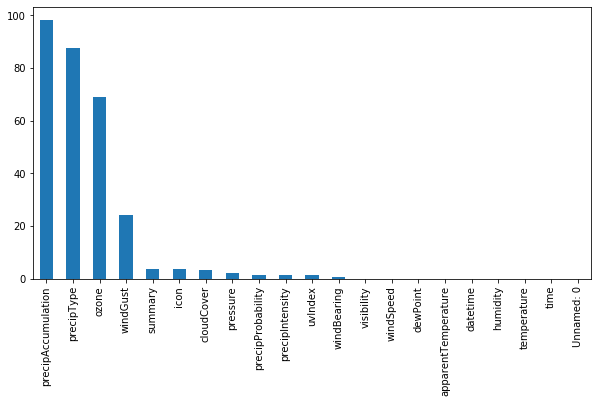

In [8]:
# perform an assessment of how much missing data there is in each column of the dataset.

missing_perc =( (darksky.isnull().sum()/darksky.shape[0]) * 100 ).sort_values(ascending=False)
missing_perc.plot.bar(figsize=(10,5), color=base_color);

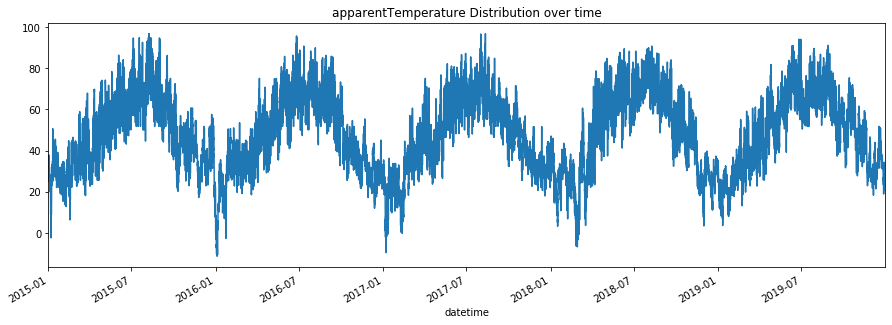

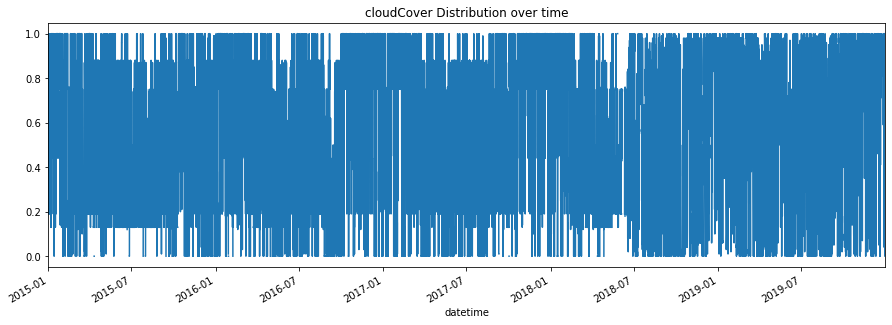

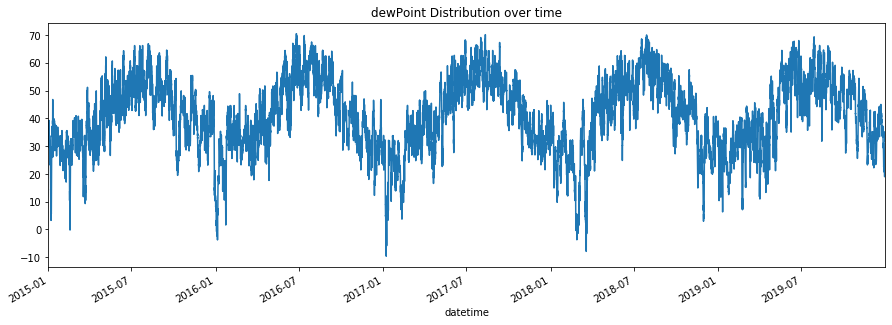

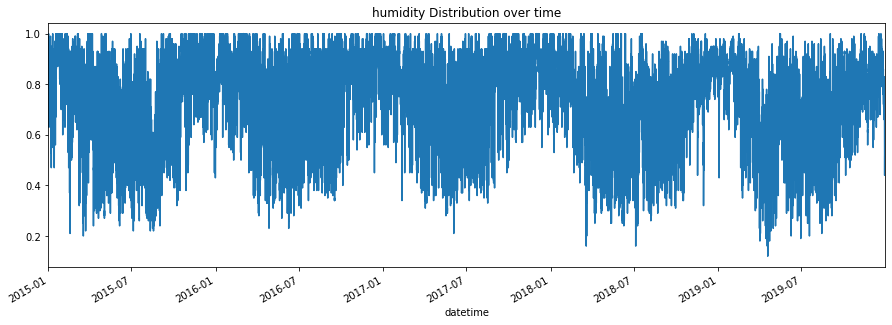

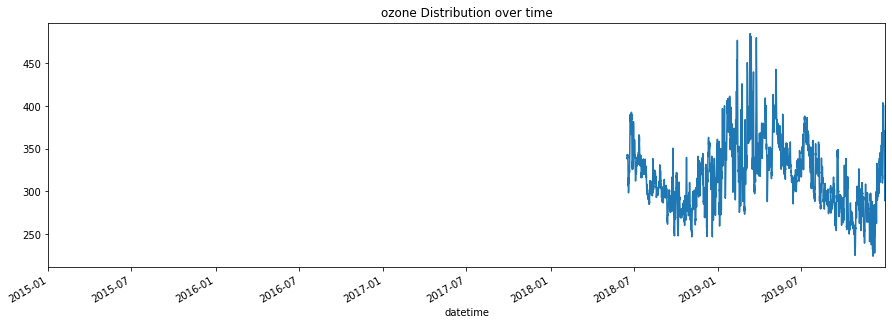

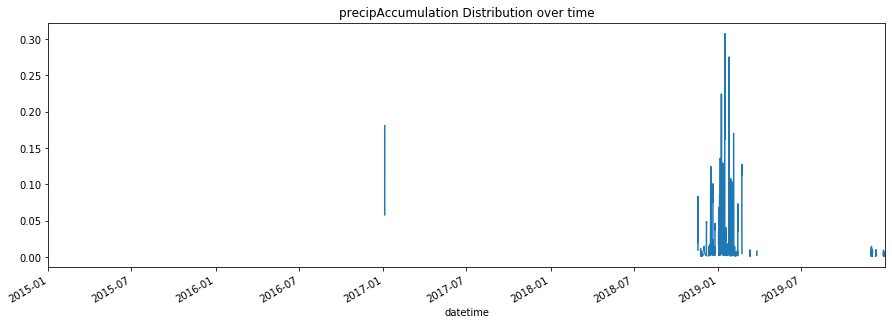

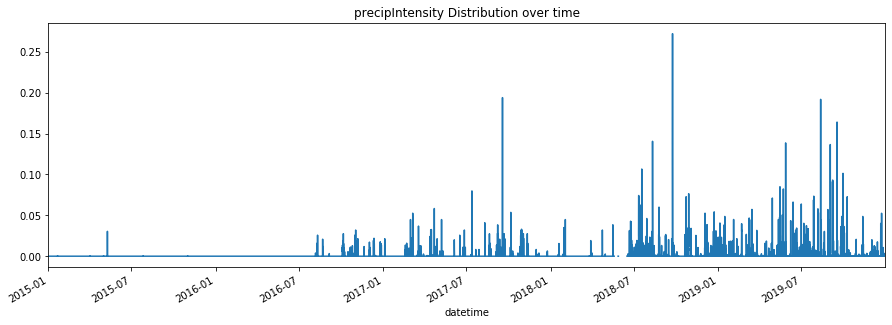

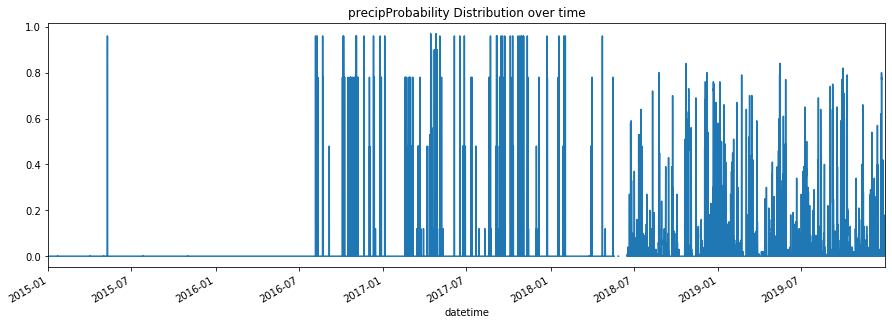

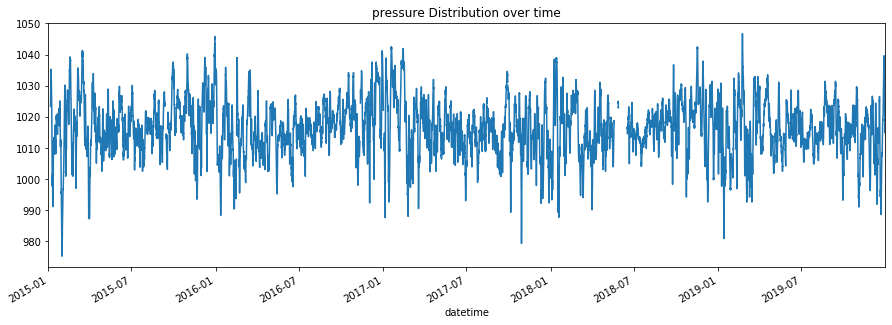

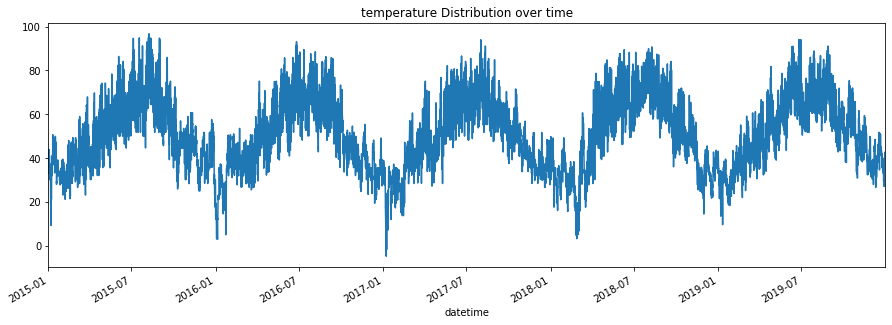

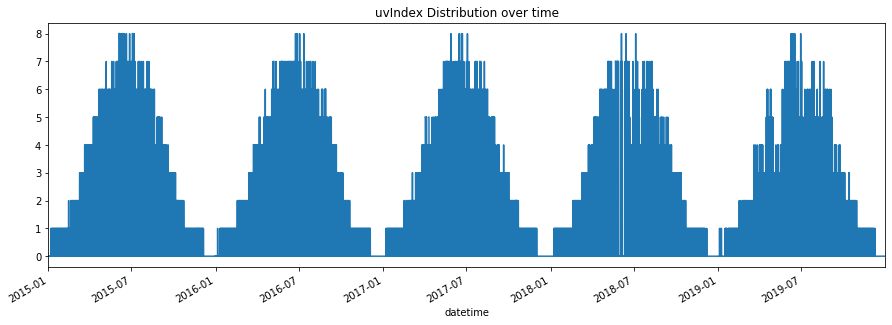

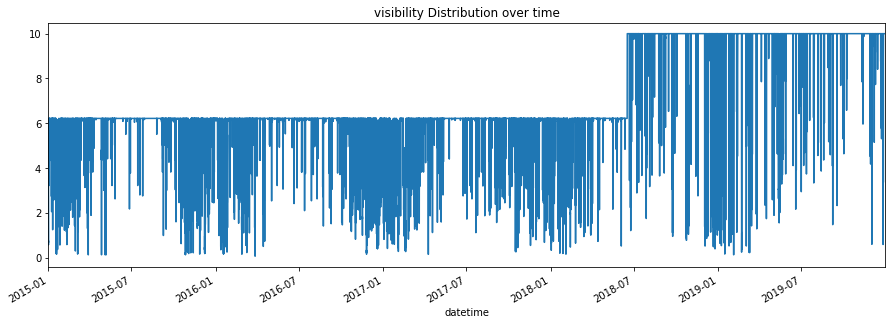

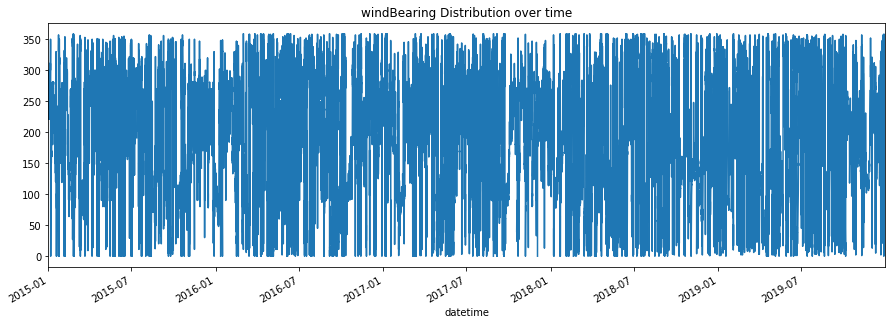

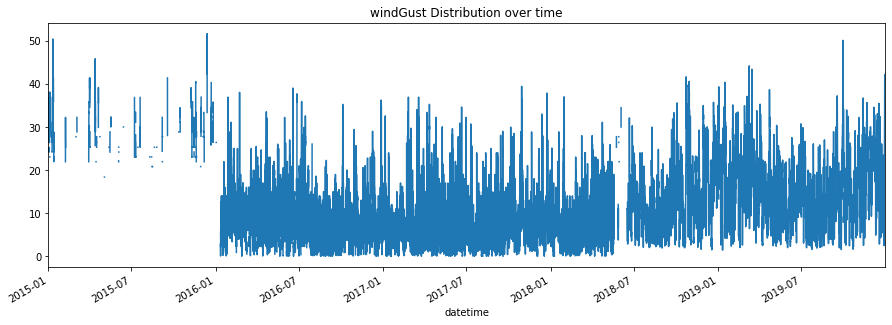

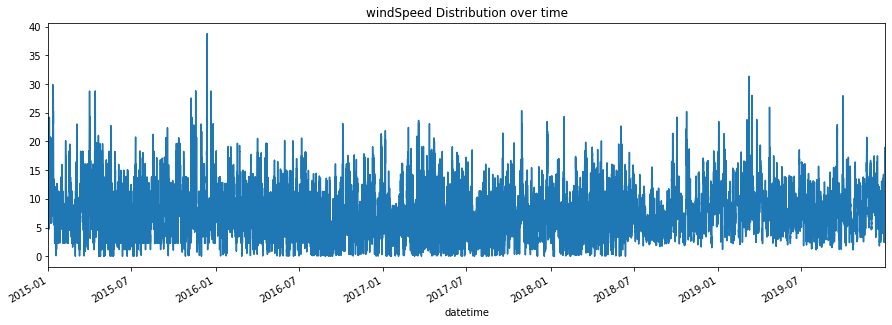

In [9]:
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'ozone',
         'precipAccumulation', 'precipIntensity', 'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windGust', 'windSpeed']


for x in feats:
    darksky_copy = darksky.copy()
    darksky_copy.index = darksky_copy.datetime
    plt.title('{} Distribution over time'.format(x))
    darksky_copy[x].plot(figsize=(15, 5));

In [10]:
# check 'object' feature called 'icon'
darksky.icon.unique()

array([nan, 'cloudy', 'fog', 'partly-cloudy-day', 'partly-cloudy-night',
       'clear-night', 'clear-day', 'wind', 'rain', 'snow', 'sleet'],
      dtype=object)

In [11]:
# check 'object' feature called 'summary'
darksky.summary.unique()

array([nan, 'Overcast', 'Foggy', 'Mostly Cloudy', 'Partly Cloudy',
       'Clear', 'Dangerously Windy and Mostly Cloudy',
       'Windy and Mostly Cloudy', 'Windy and Partly Cloudy',
       'Windy and Overcast', 'Light Rain',
       'Dangerously Windy and Partly Cloudy', 'Drizzle',
       'Possible Drizzle', 'Possible Light Rain', 'Possible Flurries',
       'Possible Light Sleet', 'Light Snow', 'Light Sleet', 'Flurries',
       'Rain', 'Light Rain and Windy', 'Possible Light Snow',
       'Possible Drizzle and Windy', 'Possible Light Rain and Windy',
       'Windy', 'Possible Light Rain and Dangerously Windy',
       'Light Rain and Dangerously Windy', 'Rain and Windy'], dtype=object)

In [12]:
# check 'object' feature called 'precipType'
darksky.precipType.unique()

array([nan, 'rain', 'snow', 'sleet'], dtype=object)

#### Pollution (PM2.5) data

In [13]:
gios.head(15)

,datetime,MzWarAlNiepo,MzWarKondrat,MzWarWokalna
0,2015-01-01 00:00:00.000,51.5034,55.4385,51.320000
1,2015-01-01 01:00:00.000,71.8204,78.0850,68.982316
2,2015-01-01 02:00:00.000,42.6996,64.4600,48.707108
3,2015-01-01 03:00:00.005,38.2824,36.2100,37.986883
4,2015-01-01 04:00:00.010,35.4194,29.5850,33.675489
5,2015-01-01 05:00:00.015,31.7384,24.3350,29.247570
6,2015-01-01 06:00:00.020,29.2844,25.7100,26.334465
7,2015-01-01 07:00:00.025,27.8938,27.8350,24.120506
8,2015-01-01 08:00:00.030,24.4582,18.3350,20.857829
9,2015-01-01 09:00:00.035,22.4132,12.4600,19.343014


In [14]:
# remove the problem of miliseconds present in the first ~100 records
gios['datetime'] = gios['datetime'].astype('datetime64[s]')

In [15]:
gios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43823 entries, 0 to 43822
Data columns (total 4 columns):
datetime        43823 non-null datetime64[ns]
MzWarAlNiepo    43255 non-null float64
MzWarKondrat    33966 non-null float64
MzWarWokalna    42533 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.3 MB


In [16]:
gios.describe()

,MzWarAlNiepo,MzWarKondrat,MzWarWokalna
count,43255.000000,33966.000000,42533.000000
mean,25.353088,21.425814,19.847616
std,16.968319,17.737967,14.691029
min,0.877018,0.010000,1.281766
25%,13.497104,9.710000,9.550000
50%,20.696796,16.700000,15.800000
75%,32.000000,27.188171,25.518796
max,187.930147,256.028970,155.365434


In [17]:
# check if missing values exist in the gios dataset
def check_missing():
    for column in gios.columns:
        missing = column, gios[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('MzWarAlNiepo', 568)
('MzWarKondrat', 9857)
('MzWarWokalna', 1290)


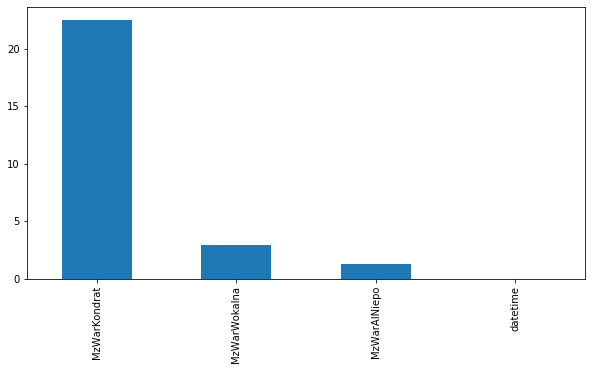

In [18]:
# perform an assessment of how much missing data there is in each column of the dataset.

missing_perc =( (gios.isnull().sum()/gios.shape[0]) * 100 ).sort_values(ascending=False)
missing_perc.plot.bar(figsize=(10,5), color=base_color);

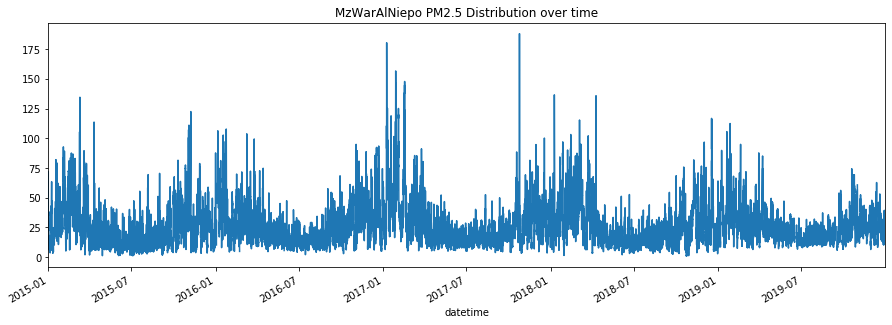

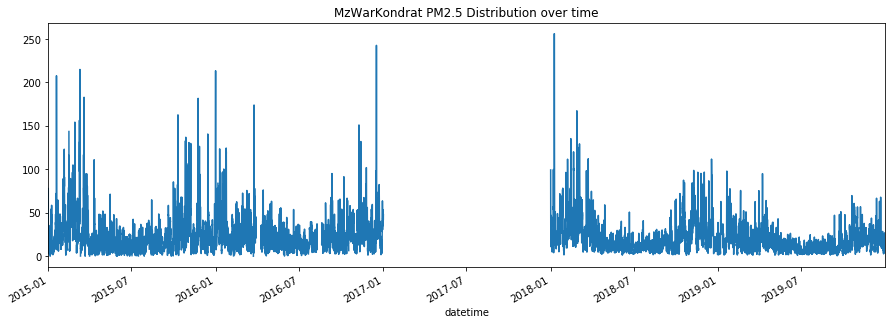

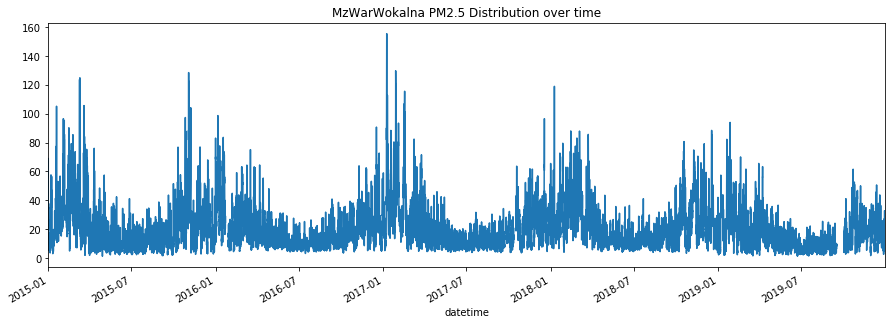

In [19]:
# check the time distribution of the missing values for MzWarAlNiepo station
feats = ['MzWarAlNiepo', 'MzWarKondrat', 'MzWarWokalna']


for x in feats:
    gios_copy = gios.copy()
    gios_copy.index = gios_copy.datetime
    plt.title('{} PM2.5 Distribution over time'.format(x))
    gios_copy[x].plot(figsize=(15, 5));

<a id='clean'></a>
## Part III - Cleaning Data

In [20]:
# before cleaning the data, let's merge the datasets on a newly created list of dates
# thanks to that we will make sure there are no dates and hours missing while merging datasets

# create a list of dates between 2015-01-01 00:00:00', end='2019-12-31 23:00:00
df_dates = pd.DataFrame(pd.date_range(start='2015-01-01', end='2020-01-01', freq='H'), columns=['datetime'])
df_dates.size

43825

In [21]:
# merge all dataset on datetime
df = pd.merge(df_dates, darksky, on=['datetime'], how='left')
df = pd.merge(df, gios, on=['datetime'], how='left')
df.head()

,datetime,Unnamed: 0,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,MzWarAlNiepo,MzWarKondrat,MzWarWokalna
0,2015-01-01 00:00:00,0.0,32.93,NaN,29.56,0.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.93,1.420067e+09,0.0,NaN,NaN,NaN,NaN,51.5034,55.4385,51.320000
1,2015-01-01 01:00:00,1.0,33.90,NaN,31.11,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.90,1.420070e+09,0.0,NaN,NaN,NaN,NaN,71.8204,78.0850,68.982316
2,2015-01-01 02:00:00,2.0,27.73,1.0,31.59,0.91,cloudy,NaN,NaN,0.0,0.0,NaN,NaN,Overcast,33.81,1.420074e+09,0.0,2.733,260.0,NaN,6.93,42.6996,64.4600,48.707108
3,2015-01-01 03:00:00,3.0,27.73,1.0,32.76,0.96,fog,NaN,NaN,0.0,0.0,NaN,NaN,Foggy,33.81,1.420078e+09,0.0,1.244,251.0,NaN,6.93,38.2824,36.2100,37.986883
4,2015-01-01 04:00:00,4.0,26.41,1.0,32.89,0.97,fog,NaN,NaN,0.0,0.0,NaN,1027.7,Foggy,33.73,1.420081e+09,0.0,1.152,251.0,NaN,8.96,35.4194,29.5850,33.675489


In [22]:
# drop unneccessary columns
df.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)

In [23]:
# assign meaningful column names for PM2.5 results
df.rename(columns={'MzWarAlNiepo':'PM25_nie', 'MzWarKondrat':'PM25_kon', 'MzWarWokalna':'PM25_wok'}, inplace=True)

In [24]:
# check last 5 rows
df.tail()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,PM25_nie,PM25_kon,PM25_wok
43844,2019-12-31 20:00:00,33.26,0.59,34.00,0.76,partly-cloudy-night,336.1,NaN,0.0,0.0,NaN,1023.3,Partly Cloudy,40.97,0.0,10.0,307.0,27.30,14.39,11.6,6.9,7.0
43845,2019-12-31 21:00:00,32.30,0.29,33.20,0.76,clear-night,337.8,NaN,0.0,0.0,NaN,1024.3,Clear,40.22,0.0,10.0,305.0,26.36,14.43,12.4,6.8,6.4
43846,2019-12-31 22:00:00,31.28,0.05,32.37,0.76,clear-night,338.0,NaN,0.0,0.0,NaN,1025.1,Clear,39.35,0.0,10.0,303.0,25.92,14.14,13.5,4.4,6.6
43847,2019-12-31 23:00:00,30.33,0.02,31.74,0.76,clear-night,334.5,NaN,0.0,0.0,NaN,1025.7,Clear,38.58,0.0,10.0,303.0,26.24,14.04,10.8,4.0,5.1
43848,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# remove 1st hour of 01-01/2020
df = df[:-1]
df.tail()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,PM25_nie,PM25_kon,PM25_wok
43843,2019-12-31 19:00:00,34.07,0.82,34.28,0.75,partly-cloudy-night,335.4,NaN,0.0,0.0,NaN,1022.5,Mostly Cloudy,41.51,0.0,10.0,307.0,28.66,14.02,11.6,6.5,7.4
43844,2019-12-31 20:00:00,33.26,0.59,34.00,0.76,partly-cloudy-night,336.1,NaN,0.0,0.0,NaN,1023.3,Partly Cloudy,40.97,0.0,10.0,307.0,27.30,14.39,11.6,6.9,7.0
43845,2019-12-31 21:00:00,32.30,0.29,33.20,0.76,clear-night,337.8,NaN,0.0,0.0,NaN,1024.3,Clear,40.22,0.0,10.0,305.0,26.36,14.43,12.4,6.8,6.4
43846,2019-12-31 22:00:00,31.28,0.05,32.37,0.76,clear-night,338.0,NaN,0.0,0.0,NaN,1025.1,Clear,39.35,0.0,10.0,303.0,25.92,14.14,13.5,4.4,6.6
43847,2019-12-31 23:00:00,30.33,0.02,31.74,0.76,clear-night,334.5,NaN,0.0,0.0,NaN,1025.7,Clear,38.58,0.0,10.0,303.0,26.24,14.04,10.8,4.0,5.1


In [26]:
# check if missing values exist in the dataset
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('apparentTemperature', 1)
('cloudCover', 1412)
('dewPoint', 1)
('humidity', 1)
('icon', 1629)
('ozone', 30335)
('precipAccumulation', 43125)
('precipIntensity', 676)
('precipProbability', 676)
('precipType', 38406)
('pressure', 928)
('summary', 1629)
('temperature', 1)
('uvIndex', 578)
('visibility', 8)
('windBearing', 286)
('windGust', 10578)
('windSpeed', 4)
('PM25_nie', 569)
('PM25_kon', 9859)
('PM25_wok', 1291)


#### Remove columns with high number of missing data

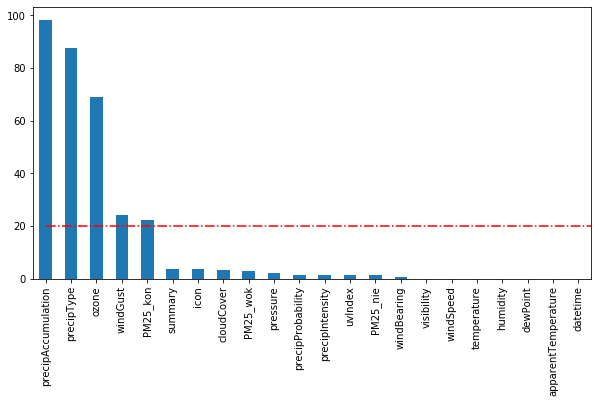

In [27]:
# perform an assessment of how much missing data there is in each column of the dataset.

missing_perc =( (df.isnull().sum()/df.shape[0]) * 100 ).sort_values(ascending=False)
missing_perc.plot.bar(figsize=(10,5), color=base_color)
plt.hlines(xmin=df.index.min(), xmax=df.index.max(), y=20, color='r', linestyle='-.');

In [28]:
# remove columns with more than 25% of missing data from the dataset.
outliers = [col for col in df.columns if missing_perc[col] > 20]
outliers

['ozone', 'precipAccumulation', 'precipType', 'windGust', 'PM25_kon']

In [29]:
# drop outlier columns
df = df.drop(outliers,axis=1)

#### Filling in missing values

In [30]:
# replace na values for categorical features with 'unknown'
df['icon'] = df['icon'].fillna('unknown')
df['summary'] = df['summary'].fillna('unknown')

In [31]:
# interpolate na values 
feats=['apparentTemperature','cloudCover', 'dewPoint', 'humidity', 'precipIntensity',
      'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing', 
      'windSpeed']

for feat in feats:
    df[feat] = df[feat].interpolate(limit_direction='both')

In [32]:
# check if missing values exist in the dataset
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('PM25_nie', 569)
('PM25_wok', 1291)


**I will fill in missing values for PM2.5 levels with the mean value for a certain mm-dd hh:mm:ss
in order to achieve this I need to extract parts of the date. On the way, I will extract more
features that might be useful.**

In [34]:
# extract parts of the date
df['hour'] = df.datetime.dt.hour
df['day'] = df.datetime.dt.day
df['dayofyear'] = df.datetime.dt.dayofyear
df['weekday'] = df.datetime.dt.weekday
df['month'] = df.datetime.dt.month
df['quarter'] = df.datetime.dt.quarter
df['year'] = df.datetime.dt.year

In [35]:
# divide a week to weekdays and weekends
df['IsWeekend'] = df['weekday'].apply(lambda x: 0 if x <5 else 1)

In [64]:
# mapping months to seasons
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer',
           'Summer', 'Summer', 'Autumn', 'Autumn', 'Autumn', 'Winter']
month_to_season = dict(zip(range(1,13), seasons))

df['season'] = df.month.map(month_to_season)

In [45]:
# group by the day of the year and hour, then compute mean value for PM2.5 per station
agg_feats = ['dayofyear', 'hour']
PM25_mean = df.groupby(agg_feats)['PM25_nie', 'PM25_wok'].agg('mean').reset_index()

In [46]:
# assign different column names, so there is no confusion while merging datasets
PM25_mean.rename(columns={'PM25_nie': 'PM25_nie_mean', 'PM25_wok': 'PM25_wok_mean'}, inplace=True)
PM25_mean.head()

In [48]:
# join datasets
df = pd.merge(df, PM25_mean, on=agg_feats, how='left')
df.head()

In [61]:
# fill missing values from the mean values
df['PM25_nie'] = df['PM25_nie'].fillna(df['PM25_nie_mean'])
df['PM25_wok'] = df['PM25_wok'].fillna(df['PM25_wok_mean'])

In [62]:
# check if missing values exist in the dataset
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

In [65]:
df.to_hdf('data/warsaw_air_pollution_2015-2019.h5', key='df', format='t')

<a id='eda'></a>
## Part IV - EDA

Wall time: 518 ms


(24.0, 0.0)

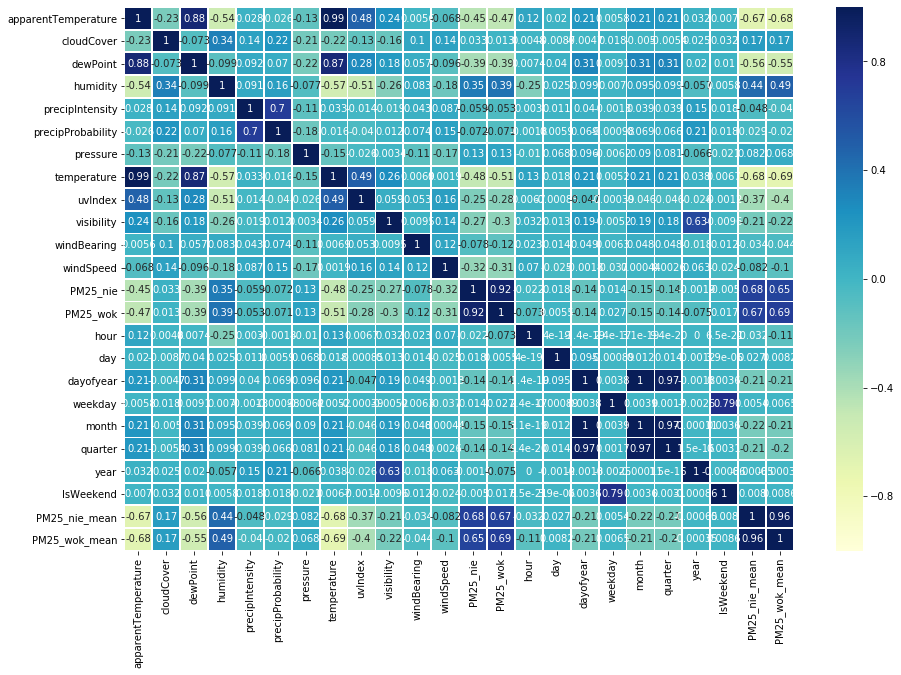

In [66]:
# plot correlation matrix
plt.rcParams['figure.figsize']=(15,10)
%time ax = sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

# correcting matplotlib issue with cutting edges
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

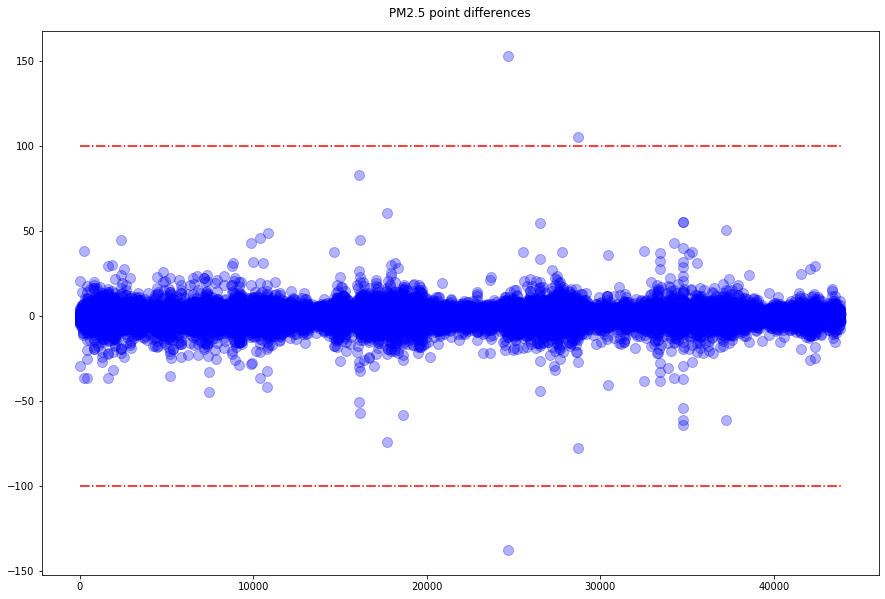

In [73]:
# check the time distribution of the missing values for MzWarAlNiepo station
plt.plot(df.index, df['PM25_nie'].diff(), 'bo', alpha=0.3, ms=10, lw='3')

plt.title("PM2.5 point differences", y=1.015)
plt.hlines(xmin=df.index.min(), xmax=df.index.max(), y=100, color='r', linestyle='-.')
plt.hlines(xmin=df.index.min(), xmax=df.index.max(), y=-100, color='r', linestyle='-.');

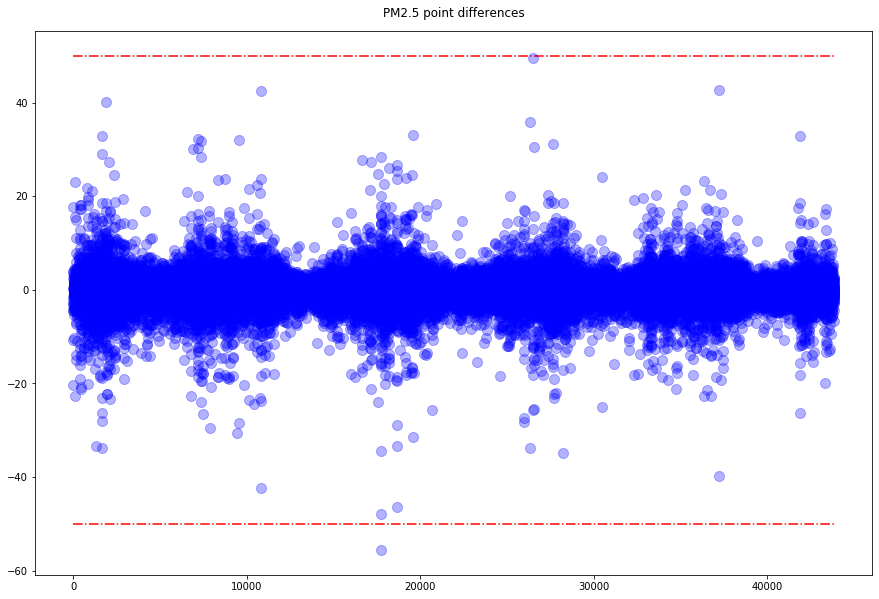

In [72]:
# check the time distribution of the missing values for MzWarAlNiepo station
plt.plot(df.index, df['PM25_wok'].diff(), 'bo', alpha=0.3, ms=10, lw='3')

plt.title("PM2.5 point differences", y=1.015)
plt.hlines(xmin=df.index.min(), xmax=df.index.max(), y=50, color='r', linestyle='-.')
plt.hlines(xmin=df.index.min(), xmax=df.index.max(), y=-50, color='r', linestyle='-.');

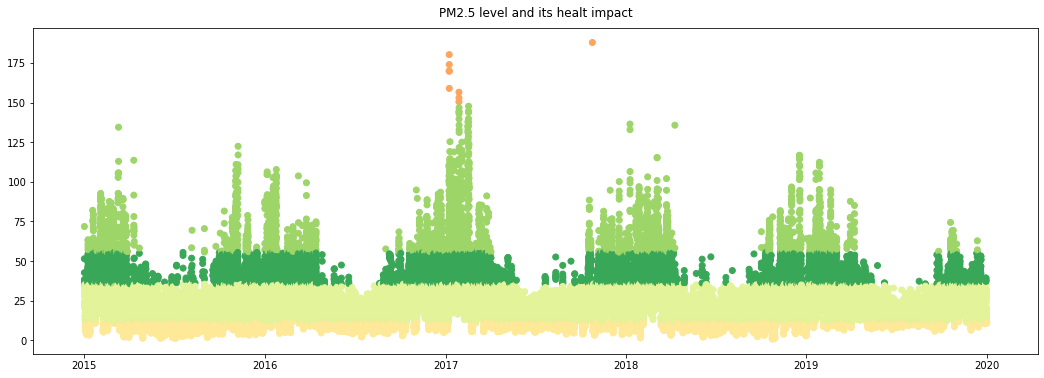

In [91]:
scatter_data = df[ ['datetime', 'PM25_nie'] ]
#scatter_data = scatter_data[ False == scatter_data['pm25_nie'].isnull() ]

bins = pd.IntervalIndex.from_tuples([ (0, 12), (12, 35.5), (35.5, 55.5), 
                                      (55.5, 150.5), (150.5, 250.5), (250.5, 500) ])
scatter_data['PM2.5_cat'] = pd.cut(scatter_data['PM25_nie'], bins)

labels=["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy","Hazardous"]
station_cat_dict = dict(zip(bins, labels))
scatter_data['PM2.5_cat'] = scatter_data['PM25_nie'].map(station_cat_dict)

#plot
plt.figure(figsize=(18, 6))
plt.title("PM2.5 level and its healt impact", y=1.015)

# Unique category labels: 'D', 'F', 'G', ...
color_labels = scatter_data['PM2.5_cat'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("RdYlGn_r", 6)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
plt.scatter(x='datetime', y='PM25_nie', data=scatter_data, c=scatter_data['PM2.5_cat'].map(color_map));

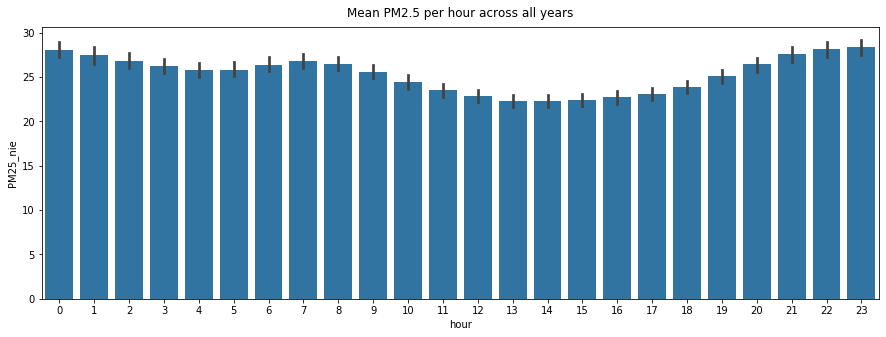

In [93]:
plt.figure(figsize=(15, 5))
plt.title("Mean PM2.5 per hour across all years", y=1.015)
sns.barplot(x="hour", y="PM25_nie", data=df, color=base_color);

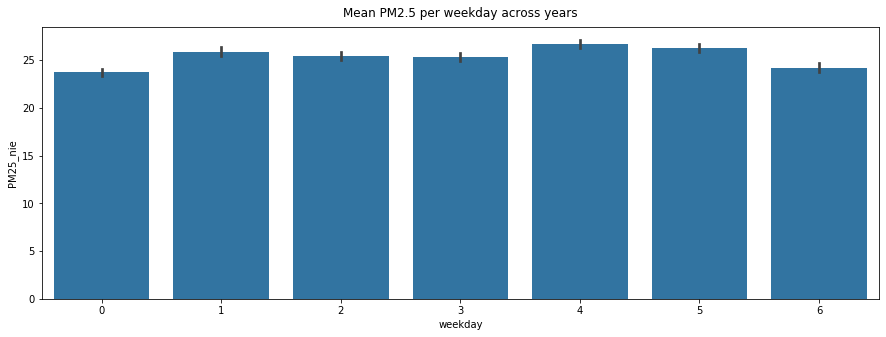

In [94]:
plt.figure(figsize=(15, 5))
plt.title("Mean PM2.5 per weekday across years", y=1.015)
sns.barplot(x="weekday", y="PM25_nie", data=df, color=base_color);

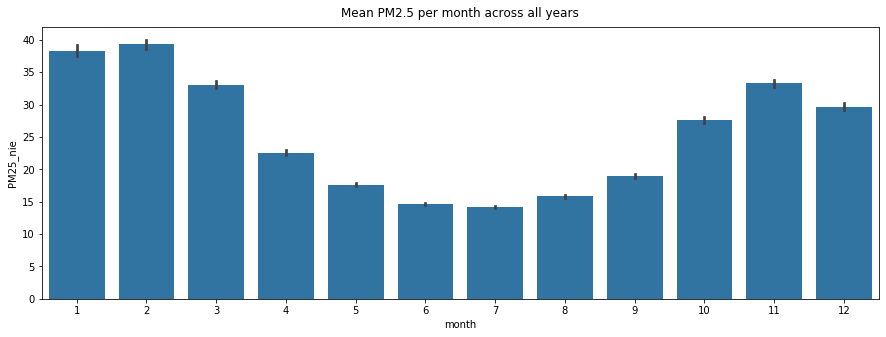

In [95]:
plt.figure(figsize=(15, 5))
plt.title("Mean PM2.5 per month across all years", y=1.015)
sns.barplot(x="month", y="PM25_nie", data=df, color=base_color);

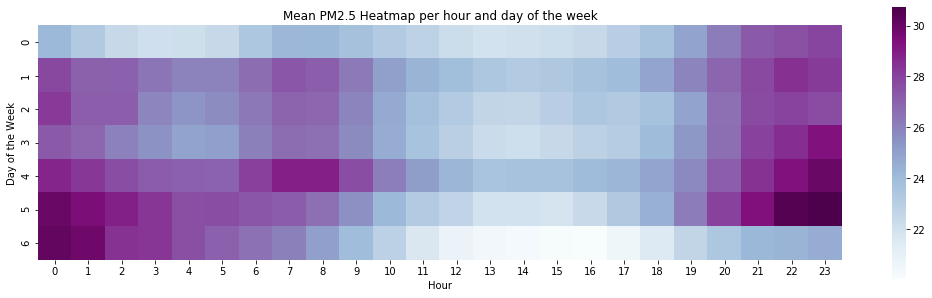

In [99]:
plt.figure(figsize=(18, 5))

# heatmap for the avg PM2.5 over the weekday and hour
df_train = df.groupby(["weekday", "hour"])["PM25_nie"].mean().reset_index()
df_train = df_train.pivot("weekday", "hour", "PM25_nie")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

# korekta błędu w matplotlib, który ucina krawędzie heatmapy
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Mean PM2.5 Heatmap per hour and day of the week", y=1.015)
plt.xlabel('Hour')
plt.ylabel('Day of the Week');

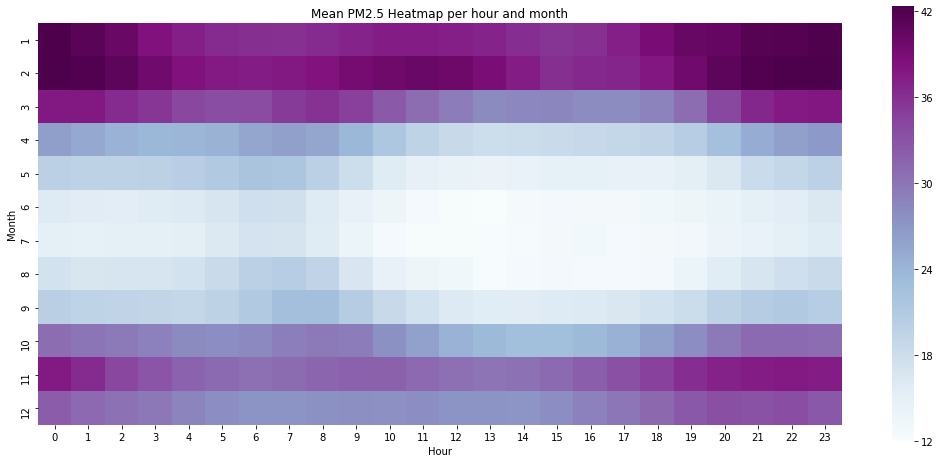

In [100]:
plt.figure(figsize=(18, 8))

# heatmap for the avg PM2.5 over the month and hour
df_train = df.groupby(["month", "hour"])["PM25_nie"].mean().reset_index()
df_train = df_train.pivot("month", "hour", "PM25_nie")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

# korekta błędu w matplotlib, który ucina krawędzie heatmapy
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Mean PM2.5 Heatmap per hour and month", y=1.015)
plt.xlabel('Hour')
plt.ylabel('Month');

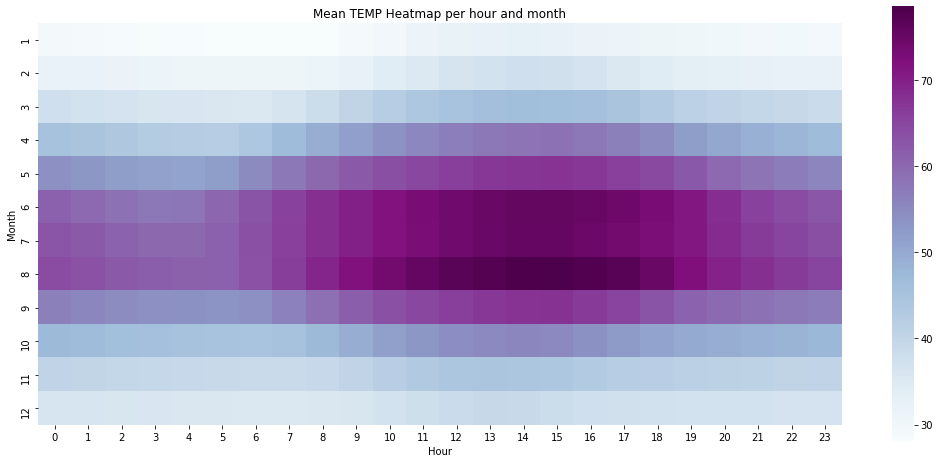

In [101]:
plt.figure(figsize=(18, 8))

# heatmap for the avg temperature over the weekday and hour
df_train = df.groupby(["month", "hour"])["temperature"].mean().reset_index()
df_train = df_train.pivot("month", "hour", "temperature")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

# korekta błędu w matplotlib, który ucina krawędzie heatmapy
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Mean TEMP Heatmap per hour and month", y=1.015)
plt.xlabel('Hour')
plt.ylabel('Month');

#### Most correlated features with PM2.5

In [102]:
# copy the data
train_bins = df.copy()

# list features to investigate
feats = ['dewPoint', 'humidity', 'temperature', 'windSpeed']

# loop through the list and create new binned features
for feat in feats:
    train_bins['{}_bins'.format(feat)] = pd.cut(train_bins[feat], bins=10)

In [108]:
def pm_25_per_feature(bin_feature, pm):
    plt.figure(figsize=(15, 5))
    plt.title("Mean PM2.5 per {}".format(bin_feature), y=1.015)
    chart = sns.barplot(x=bin_feature, y=pm, data=train_bins, color=base_color)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

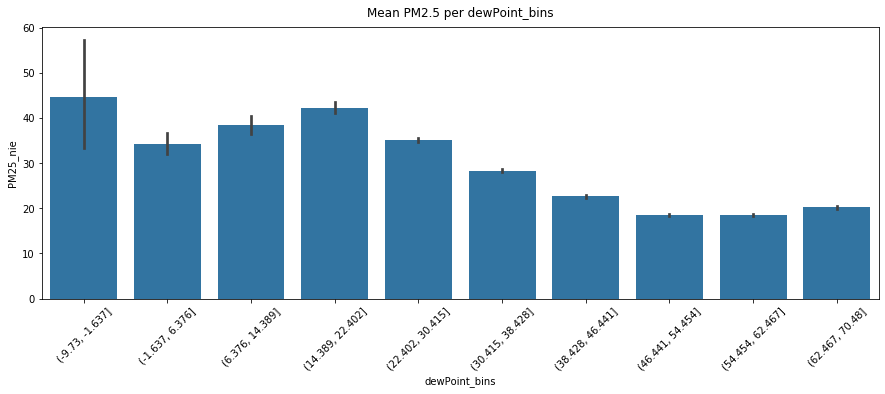

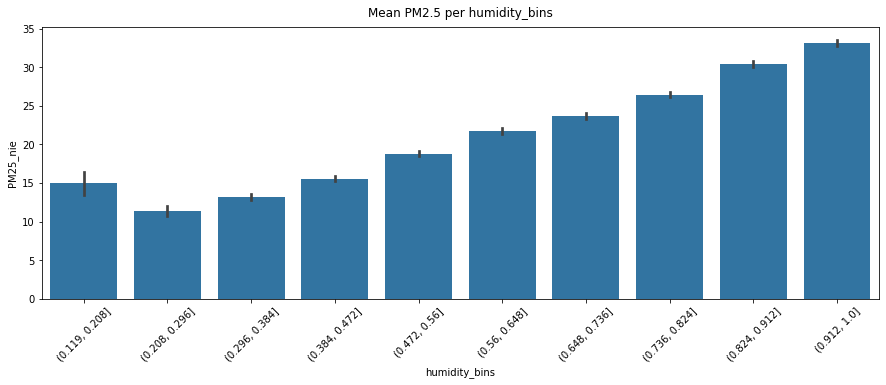

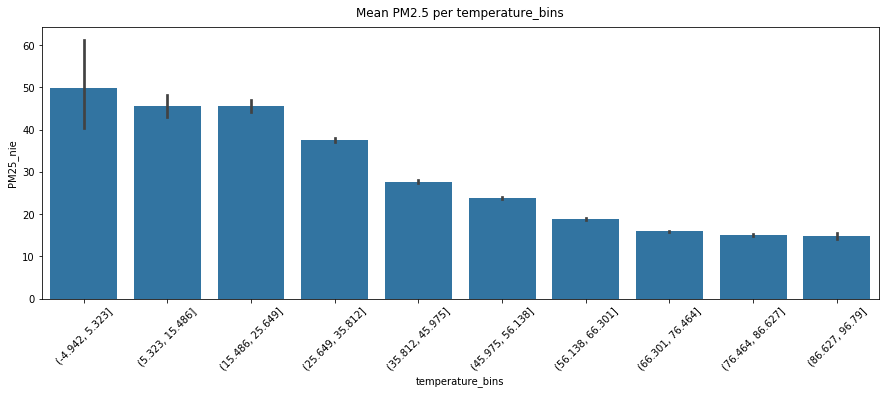

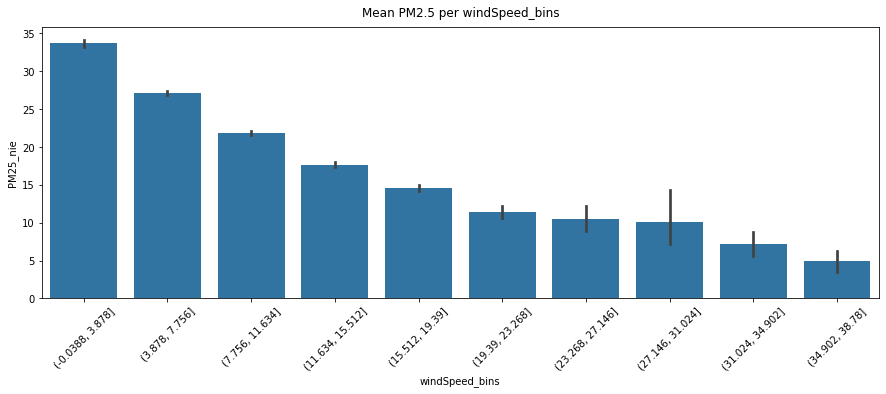

In [109]:
# list features to investigate
feats = ['dewPoint_bins', 'humidity_bins', 'temperature_bins', 'windSpeed_bins']

for feat in feats:
    pm_25_per_feature(feat, 'PM25_nie')